In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from joblib import dump, load

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM2D, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, TimeDistributed, Input
from keras.layers.merge import concatenate
from keras.utils import plot_model

import xgboost as xgb

### Utility functions

In [24]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    roll_mean = timeseries.rolling(12).mean()
    roll_std = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    ### Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    
    # The number of lags is chosen to minimise the Akaike's Information Criterion (AIC)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    print('\n\n')
    
    ### Perform KPSS test:
    print ('Results of KPSS Test:')
    
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [25]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [26]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [False,True] # classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Data Preprocessing

In [27]:
data = pd.read_csv('exoTrain.csv')

In [28]:
data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [29]:
X = data.iloc[:,1:]
y = data.iloc[:,0] - 1

In [30]:
ts_diff = X.copy()

for i in range(X.shape[0]):
    ts_diff.iloc[i,:] = X.iloc[i,:] - X.iloc[i,:].shift()
    ts_diff.iloc[i,:] = ts_diff.iloc[i,:].fillna(method='ffill').fillna(method='bfill')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(ts_diff, y, test_size=0.2)

## XGBoost

In [10]:
xgb_model = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

### Hyperparameter Optimisation

In [ ]:
grid = GridSearchCV(xgb_model,
                    parameters, n_jobs=-1,
                    scoring="neg_log_loss",
                    cv=3,
                    verbose=1)

xgboost_model = grid.fit(X_train, y_train)

In [ ]:
params = xgboost_model.best_params_

In [ ]:
dump(xgboost_model, 'xgb_opt.joblib') 

### Fit and visualise

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

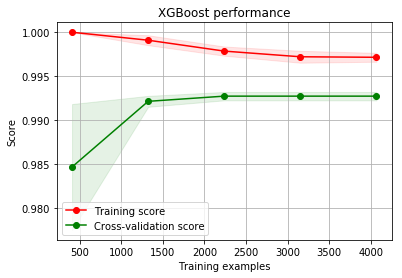

In [32]:
cv = StratifiedKFold(n_splits=5)
model = xgb.XGBClassifier(colsample_bytree = 0.7, eta = 0.1, gamma = 0.0, max_depth = 2, min_child_weight = 1)
plot_learning_curve(model, 'XGBoost performance', X, y, cv=cv)

In [33]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.1, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [34]:
dump(model, 'xgb.joblib')

['xgb.joblib']

In [35]:
preds = model.predict(X_test)

Confusion matrix, without normalization
[[1009    0]
 [   0    9]]


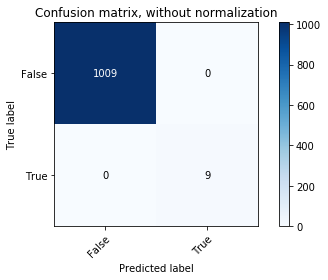

In [36]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, preds,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


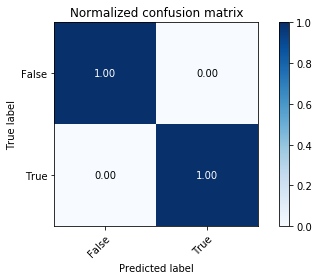

In [37]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, preds, normalize=True,
                      title='Normalized confusion matrix')

In [38]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1009
           1       1.00      1.00      1.00         9

   micro avg       1.00      1.00      1.00      1018
   macro avg       1.00      1.00      1.00      1018
weighted avg       1.00      1.00      1.00      1018



## MLP

### Model design

In [39]:
mlp_model = Sequential()
mlp_model.add(Dense(4,input_dim=X.shape[1], activation='relu'))
mlp_model.add(Dense(1, activation='sigmoid'))

In [40]:
mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 12792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 12,797
Trainable params: 12,797
Non-trainable params: 0
_________________________________________________________________


In [41]:
mlp_model.compile(loss='mean_squared_error', optimizer='adam')

### Model fitting

In [42]:
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1, validation_data=(X_test, y_test))

Train on 4069 samples, validate on 1018 samples
Epoch 1/20
4069/4069 [==============================] - 1s 205us/step - loss: 0.5242 - val_loss: 0.4230
Epoch 2/20
4069/4069 [==============================] - 1s 239us/step - loss: 0.3892 - val_loss: 0.3957
Epoch 3/20
4069/4069 [==============================] - 1s 230us/step - loss: 0.3522 - val_loss: 0.3748
Epoch 4/20
4069/4069 [==============================] - 1s 241us/step - loss: 0.3199 - val_loss: 0.3438
Epoch 5/20
4069/4069 [==============================] - 1s 242us/step - loss: 0.2902 - val_loss: 0.3145
Epoch 6/20
4069/4069 [==============================] - 1s 199us/step - loss: 0.2651 - val_loss: 0.2914
Epoch 7/20
4069/4069 [==============================] - 1s 170us/step - loss: 0.2349 - val_loss: 0.2578
Epoch 8/20
4069/4069 [==============================] - 1s 180us/step - loss: 0.1945 - val_loss: 0.2089
Epoch 9/20
4069/4069 [==============================] - 1s 168us/step - loss: 0.1583 - val_loss: 0.1626
Epoch 10/20
4069

In [43]:
# Save the model
mlp_model.save('mlp_exoplanet_model.h5')

### Performance evaluation

In [44]:
score = mlp_model.evaluate(X_test, y_test, verbose=1)
print('The MSE on the test set is: ', score)

1018/1018 [==============================] - 0s 35us/step
The MSE on the test set is:  0.02218853100557484


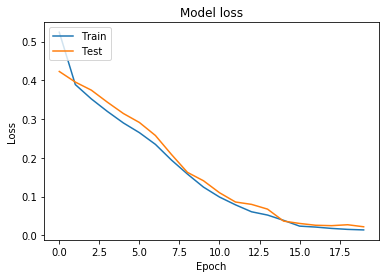

In [45]:
# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()